# Documentation

**Author:** Anirudh  
**Date:** 09/04/2025  

### Details:
- **Modeling:** Using Linear mixed models now to study the longitudinal changes with respective to Diagnosis (Given BL_DX how cognitive changes overtime with sleep variables)
    - Two types of models to be made : 1. MRI, Cognitive, Sociodemographics. 2. MRI, Cognitive, APOE4, BMI, Cardiovascular risks [Using RID as random effect]
- **Transitions:** Check transitions for Diagnosis and NPIKSEV over time.
    - Flat = no changes 
    - Improves  
    - Worsen 
    - Mixed changes 

In [65]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [66]:
volumes_data = pd.read_csv("Updated_merge.csv")
sleep_data = pd.read_csv("Updated_sleep.csv")
bmi = pd.read_csv("Updated_BMI.csv")

In [67]:
volumes_data = pd.merge(volumes_data, bmi,on='RID')

In [68]:
merge = pd.merge(volumes_data, sleep_data, on=['RID', 'VISCODE'])

In [69]:
merge = merge.drop(['MHDESC'],axis=1)

In [70]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
mri_outcomes = ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal', 'LeftParsOpercularis', 'LeftParsOrbitalis', 'LeftParsTriangularis', 'LeftPericalcarine', 'LeftPostcentral', 'LeftPosteriorCingulate', 'LeftPrecentral', 'LeftPrecuneus', 'LeftRostralAnteriorCingulate', 'LeftRostralMiddleFrontal',
            'LeftSuperiorFrontal', 'LeftSuperiorParietal', 'LeftSuperiorTemporal', 'LeftSupramarginal', 'LeftTemporalPole', 'LeftTransverseTemporal', 'LeftUnknown', 'RightBankssts', 'RightCaudalAnteriorCingulate', 'RightCaudalMiddleFrontal', 'RightCuneus', 'RightEntorhinal', 'RightFrontalPole', 'RightFusiform', 'RightInferiorParietal', 'RightInferiorTemporal', 'RightIsthmusCingulate', 'RightLateralOccipital', 'RightLateralOrbitofrontal', 'RightLingual', 'RightMedialOrbitofrontal', 'RightMiddleTemporal', 'FourthVentricle', 'Icv', 'LeftAccumbensArea', 'LeftAmygdala', 'LeftCaudate', 'LeftCerebellumCortex', 'LeftCerebellumWM', 'LeftCerebralCortex', 'LeftCerebralWM', 'LeftChoroidPlexus', 'LeftHemisphere', 'LeftHippocampus', 'LeftInferiorLateralVentricle', 'LeftLateralVentricle', 'LeftPallidum', 'LeftPutamen', 'LeftThalamus', 'LeftVentralDC', 'LeftVessel', 'NonWMHypoIntensities', 'OpticChiasm', 'RightAccumbensArea', 'RightAmygdala', 'RightCaudate', 'RightCerebellumCortex', 'RightCerebellumWM', 'RightCerebralCortex', 'RightCerebralWM', 'RightChoroidPlexus', 'RightHemisphere', 'RightHippocampus', 'RightInferiorLateralVentricle', 'RightLateralVentricle', 'RightPallidum', 'RightPutamen', 'RightThalamus', 'RightVentralDC', 'ThirdVentricle', 'WMHypoIntensities']

In [71]:
set(merge.columns) - set(mri_outcomes) - set(cognitive_outcomes) - set(sleep_vars)

{'AGE',
 'APOE4',
 'Adjusted_Age',
 'BMI',
 'DX',
 'DX_bl',
 'ICV',
 'MH19OTHR',
 'MH2NEURL',
 'MH4CARD',
 'MH5RESP',
 'MHPSYCH',
 'PTEDUCAT',
 'PTETHCAT',
 'PTGENDER',
 'PTMARRY',
 'PTRACCAT',
 'RID',
 'Sleep_Quality',
 'VISCODE'}

In [72]:
model1_preds = ['AGE', 'PTEDUCAT',
                'PTETHCAT',
                'PTGENDER',
                'PTMARRY',
                'PTRACCAT',
                'DX']

In [73]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes + sleep_vars + mri_outcomes + ['BMI']
)
merge_scaled = merge.copy()
scaler = StandardScaler()

merge_scaled[continuous_vars] = scaler.fit_transform(
    merge_scaled[continuous_vars])

In [33]:
LMM_results_cognitive = []
LMM_results_mri = []

model_counter = 1

for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge["RID"])
            result = model.fit(reml=False)

            for feature in model1_preds + [sleep_var]:
                LMM_results_cognitive.append({
                    'Model_ID': f"model_{model_counter}",
                    'Model_Name': f"{outcome}_{feature}",
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': result.params.get(feature, float('nan')),
                    'P-Value': result.pvalues.get(feature, float('nan')),
                    'Sleep_Variable': sleep_var,
                })

            model_counter += 1

        except Exception as e:
            print(
                f"[Cognitive] Error fitting model for {outcome} with {sleep_var}: {e}")

 
for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge["RID"])
            result = model.fit(reml=False)

            for feature in model1_preds + [sleep_var]:
                LMM_results_mri.append({
                    'Model_ID': f"model_{model_counter}",
                    'Model_Name': f"{outcome}_{feature}",
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': result.params.get(feature, float('nan')),
                    'P-Value': result.pvalues.get(feature, float('nan')),
                    'Sleep_Variable': sleep_var,
                })

            model_counter += 1

        except Exception as e:
            print(
                f"[MRI] Error fitting model for {outcome} with {sleep_var}: {e}")

In [34]:
LMM_results_cognitive_df = pd.DataFrame(LMM_results_cognitive)

In [35]:
LMM_results_mri_df = pd.DataFrame(LMM_results_mri)

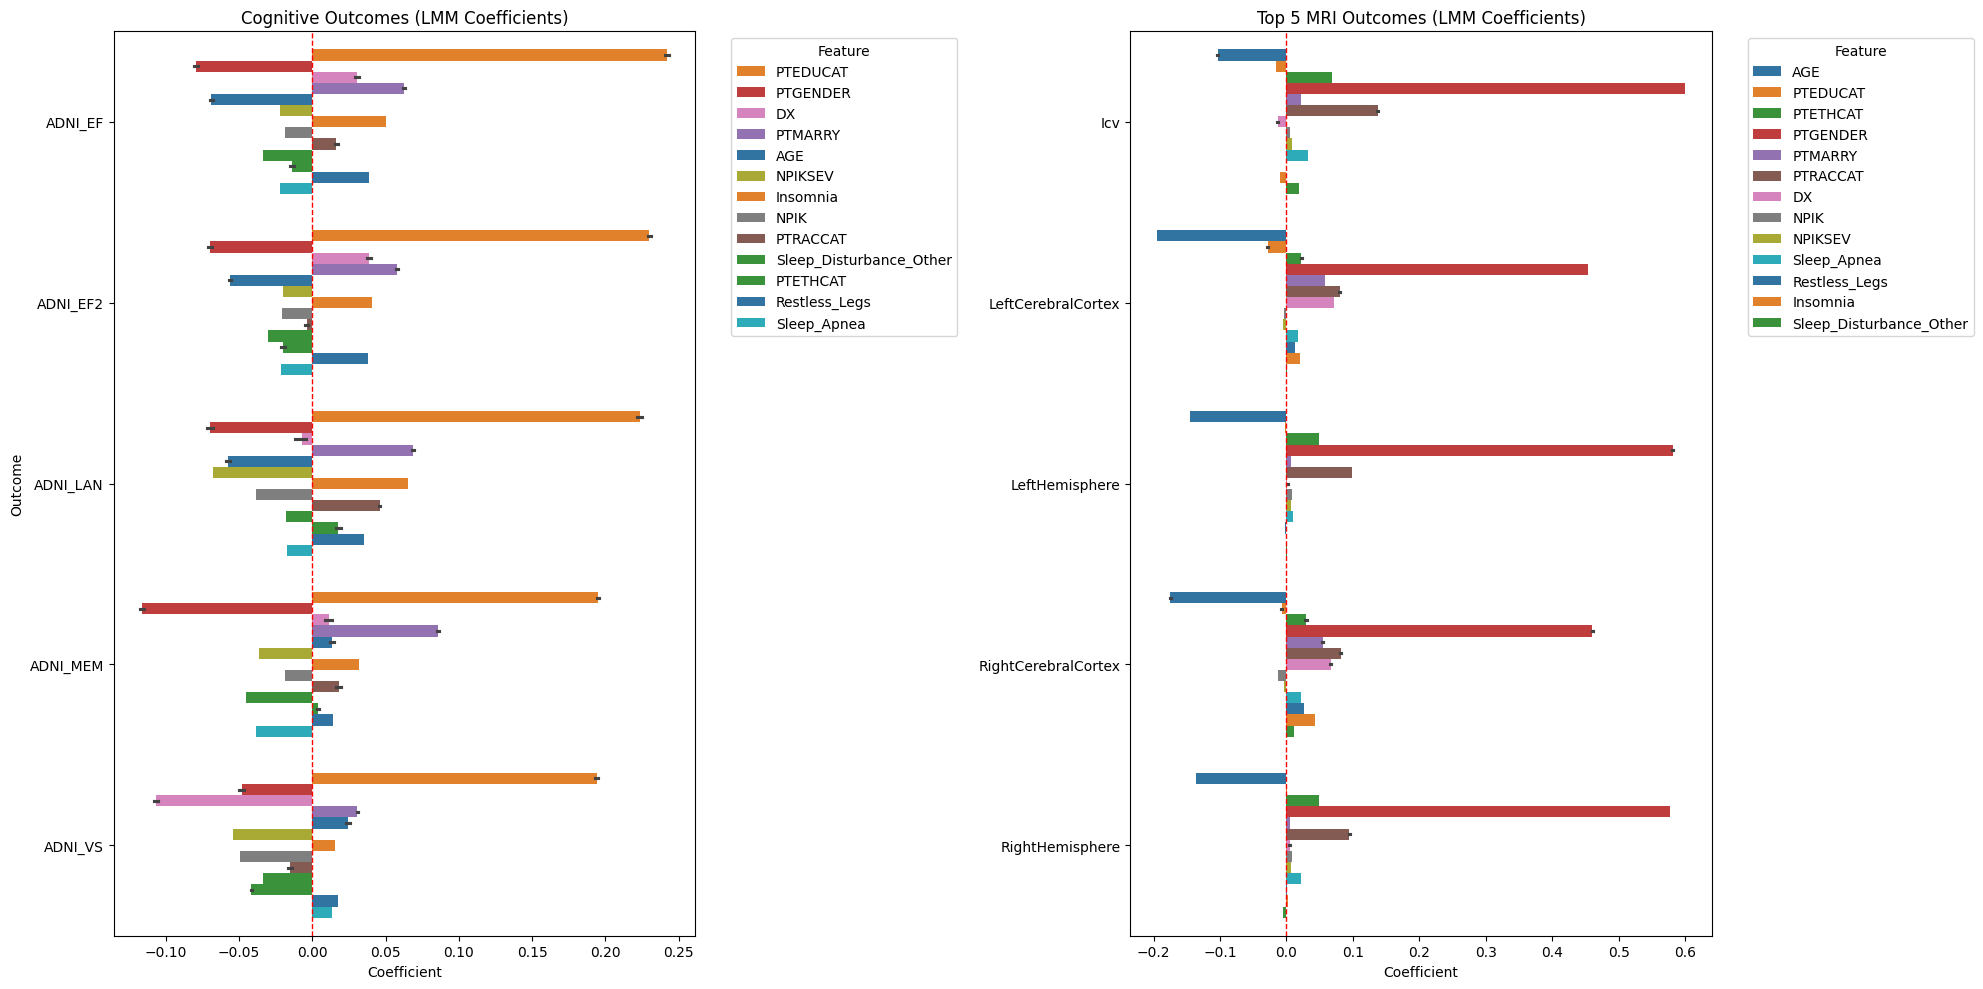

In [36]:
LMM_results_cognitive_df['Type'] = 'Cognitive'
LMM_results_mri_df['Type'] = 'MRI'
combined_LMM_results = pd.concat(
    [LMM_results_cognitive_df, LMM_results_mri_df])
top_5_mri_LMM = (
    combined_LMM_results[combined_LMM_results['Type'] == 'MRI']
    .groupby('Outcome')['Coefficient']
    .apply(lambda x: x.abs().max())
    .nlargest(5)
    .reset_index()
)

filtered_LMM_mri = combined_LMM_results.merge(
    top_5_mri_LMM[['Outcome']], on='Outcome')

filtered_LMM_cognitive = (
    combined_LMM_results[combined_LMM_results['Type'] == 'Cognitive']
    .sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)
)

features = combined_LMM_results['Feature'].unique()
palette = sns.color_palette("tab10", len(features))
color_dict = dict(zip(features, palette))

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

sns.barplot(
    data=filtered_LMM_cognitive,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[0],
    palette=color_dict
)
axes[0].set_title('Cognitive Outcomes (LMM Coefficients)')
axes[0].set_xlabel('Coefficient')
axes[0].set_ylabel('Outcome')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(
    data=filtered_LMM_mri,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[1],
    palette=color_dict
)
axes[1].set_title('Top 5 MRI Outcomes (LMM Coefficients)')
axes[1].set_xlabel('Coefficient')
axes[1].set_ylabel('')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[1].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('supplementary_tables/Top_5_LMM_Coefficients_Subplots.png',
            bbox_inches='tight')
plt.show()

In [41]:
memory_outcomes = cognitive_outcomes
top_5_mri_outcomes = filtered_LMM_mri['Outcome'].unique()

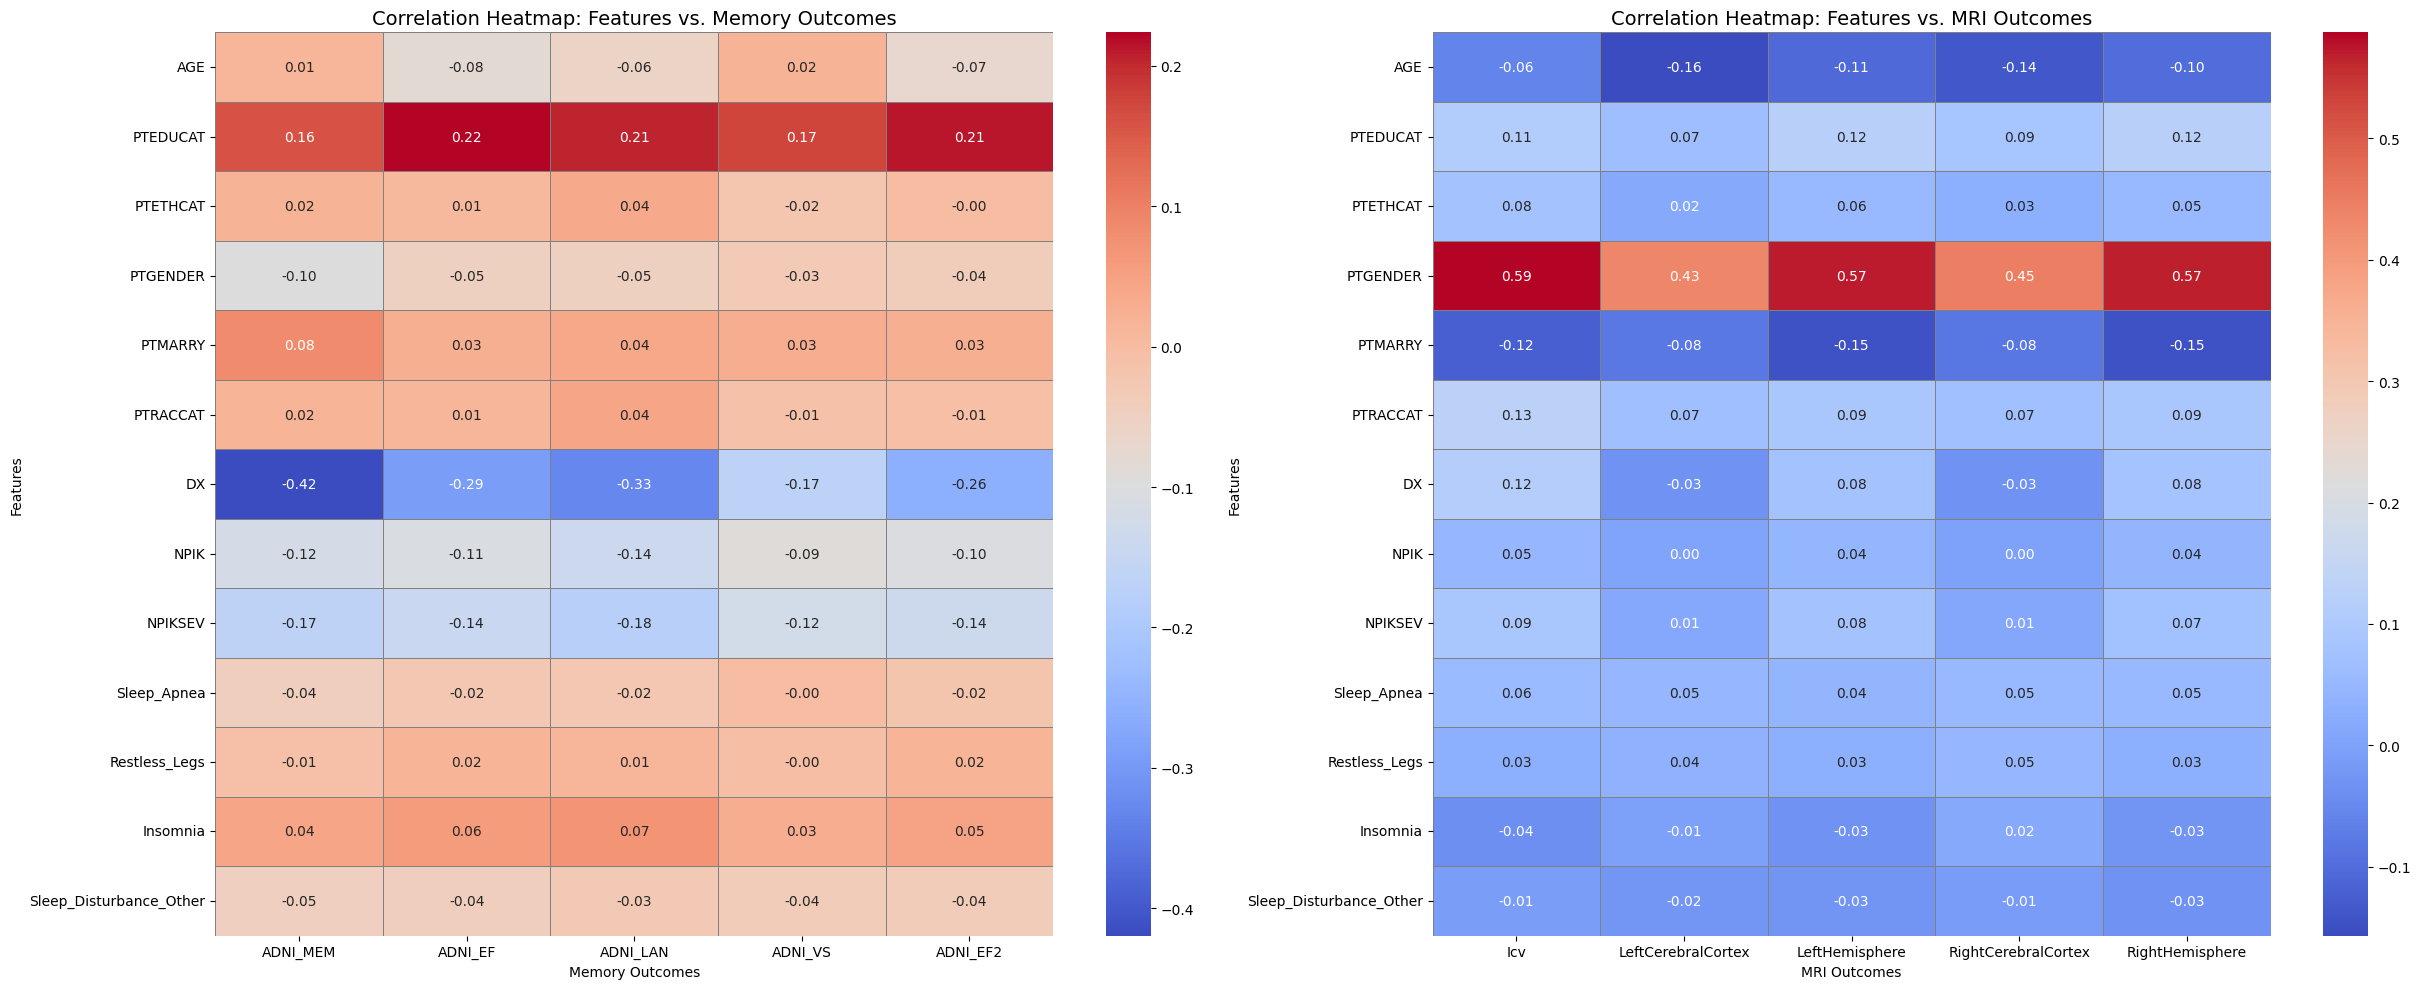

In [ ]:
combined_features = model1_preds + sleep_vars
memory_corr_columns = [col for col in combined_features + memory_outcomes if col in merge.columns]
mri_corr_columns = [col for col in combined_features + list(top_5_mri_outcomes) if col in merge.columns]
memory_corr_data = merge[memory_corr_columns].dropna()
mri_corr_data = merge[mri_corr_columns].dropna()

correlation_memory = memory_corr_data.corr()
correlation_memory_features = correlation_memory.loc[
    [col for col in combined_features if col in memory_corr_data.columns],
    [col for col in memory_outcomes if col in memory_corr_data.columns]
]

correlation_mri = mri_corr_data.corr()
correlation_mri_features = correlation_mri.loc[
    [col for col in combined_features if col in mri_corr_data.columns],
    [col for col in top_5_mri_outcomes if col in mri_corr_data.columns]
]
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.heatmap(
    correlation_memory_features, annot=True, fmt=".2f",
    cmap='coolwarm', cbar=True, ax=axes[0], linewidths=0.5, linecolor='gray'
)
axes[0].set_title(
    'Correlation Heatmap: Features vs. Memory Outcomes', fontsize=14)
axes[0].set_xlabel('Memory Outcomes')
axes[0].set_ylabel('Features')
sns.heatmap(
    correlation_mri_features, annot=True, fmt=".2f",
    cmap='coolwarm', cbar=True, ax=axes[1], linewidths=0.5, linecolor='gray'
)
axes[1].set_title(
    'Correlation Heatmap: Features vs. MRI Outcomes', fontsize=14)
axes[1].set_xlabel('MRI Outcomes')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.show()

In [63]:
model2_preds = ['APOE4', 'BMI','MH19OTHR',
                'MH2NEURL',
                'MH4CARD',
                'MH5RESP',
                'MHPSYCH',
                'DX']

In [76]:
LMM_results_cognitive = []
LMM_results_mri = []

model_counter = 1

for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge["RID"])
            result = model.fit(reml=False)

            for feature in model2_preds + [sleep_var]:
                LMM_results_cognitive.append({
                    'Model_ID': f"model_{model_counter}",
                    'Model_Name': f"{outcome}_{feature}",
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': result.params.get(feature, float('nan')),
                    'P-Value': result.pvalues.get(feature, float('nan')),
                    'Sleep_Variable': sleep_var,
                })

            model_counter += 1

        except Exception as e:
            print(
                f"[Cognitive] Error fitting model for {outcome} with {sleep_var}: {e}")


for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge["RID"])
            result = model.fit(reml=False)

            for feature in model2_preds + [sleep_var]:
                LMM_results_mri.append({
                    'Model_ID': f"model_{model_counter}",
                    'Model_Name': f"{outcome}_{feature}",
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': result.params.get(feature, float('nan')),
                    'P-Value': result.pvalues.get(feature, float('nan')),
                    'Sleep_Variable': sleep_var,
                })

            model_counter += 1

        except Exception as e:
            print(
                f"[MRI] Error fitting model for {outcome} with {sleep_var}: {e}")

In [77]:
LMM_results_cognitive_df = pd.DataFrame(LMM_results_cognitive)
LMM_results_mri_df = pd.DataFrame(LMM_results_mri)

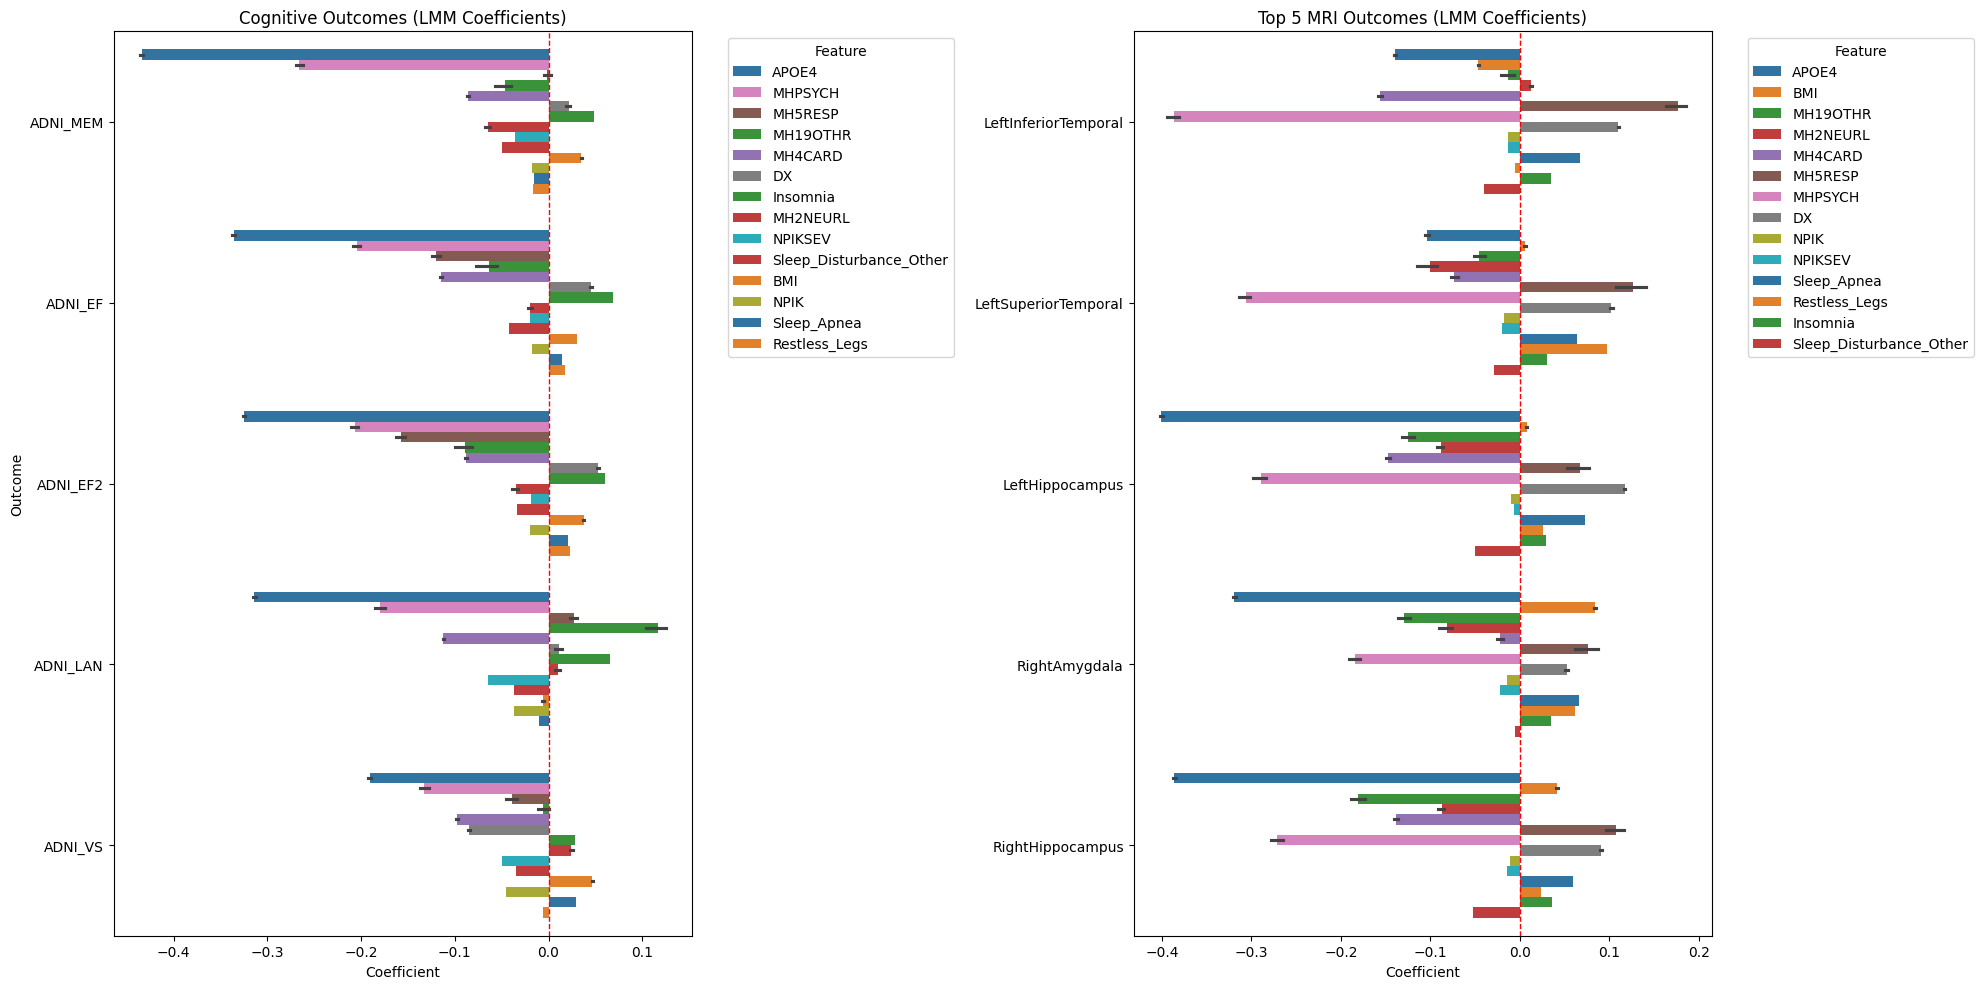

In [78]:
LMM_results_cognitive_df['Type'] = 'Cognitive'
LMM_results_mri_df['Type'] = 'MRI'
combined_LMM_results = pd.concat(
    [LMM_results_cognitive_df, LMM_results_mri_df])
top_5_mri_LMM = (
    combined_LMM_results[combined_LMM_results['Type'] == 'MRI']
    .groupby('Outcome')['Coefficient']
    .apply(lambda x: x.abs().max())
    .nlargest(5)
    .reset_index()
)

filtered_LMM_mri = combined_LMM_results.merge(
    top_5_mri_LMM[['Outcome']], on='Outcome')

filtered_LMM_cognitive = (
    combined_LMM_results[combined_LMM_results['Type'] == 'Cognitive']
    .sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)
)

features = combined_LMM_results['Feature'].unique()
palette = sns.color_palette("tab10", len(features))
color_dict = dict(zip(features, palette))

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

sns.barplot(
    data=filtered_LMM_cognitive,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[0],
    palette=color_dict
)
axes[0].set_title('Cognitive Outcomes (LMM Coefficients)')
axes[0].set_xlabel('Coefficient')
axes[0].set_ylabel('Outcome')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(
    data=filtered_LMM_mri,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[1],
    palette=color_dict
)
axes[1].set_title('Top 5 MRI Outcomes (LMM Coefficients)')
axes[1].set_xlabel('Coefficient')
axes[1].set_ylabel('')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[1].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('supplementary_tables/Top_5_LMM_Coefficients_Subplots.png',
            bbox_inches='tight')
plt.show()

In [79]:
memory_outcomes = cognitive_outcomes
top_5_mri_outcomes = filtered_LMM_mri['Outcome'].unique()

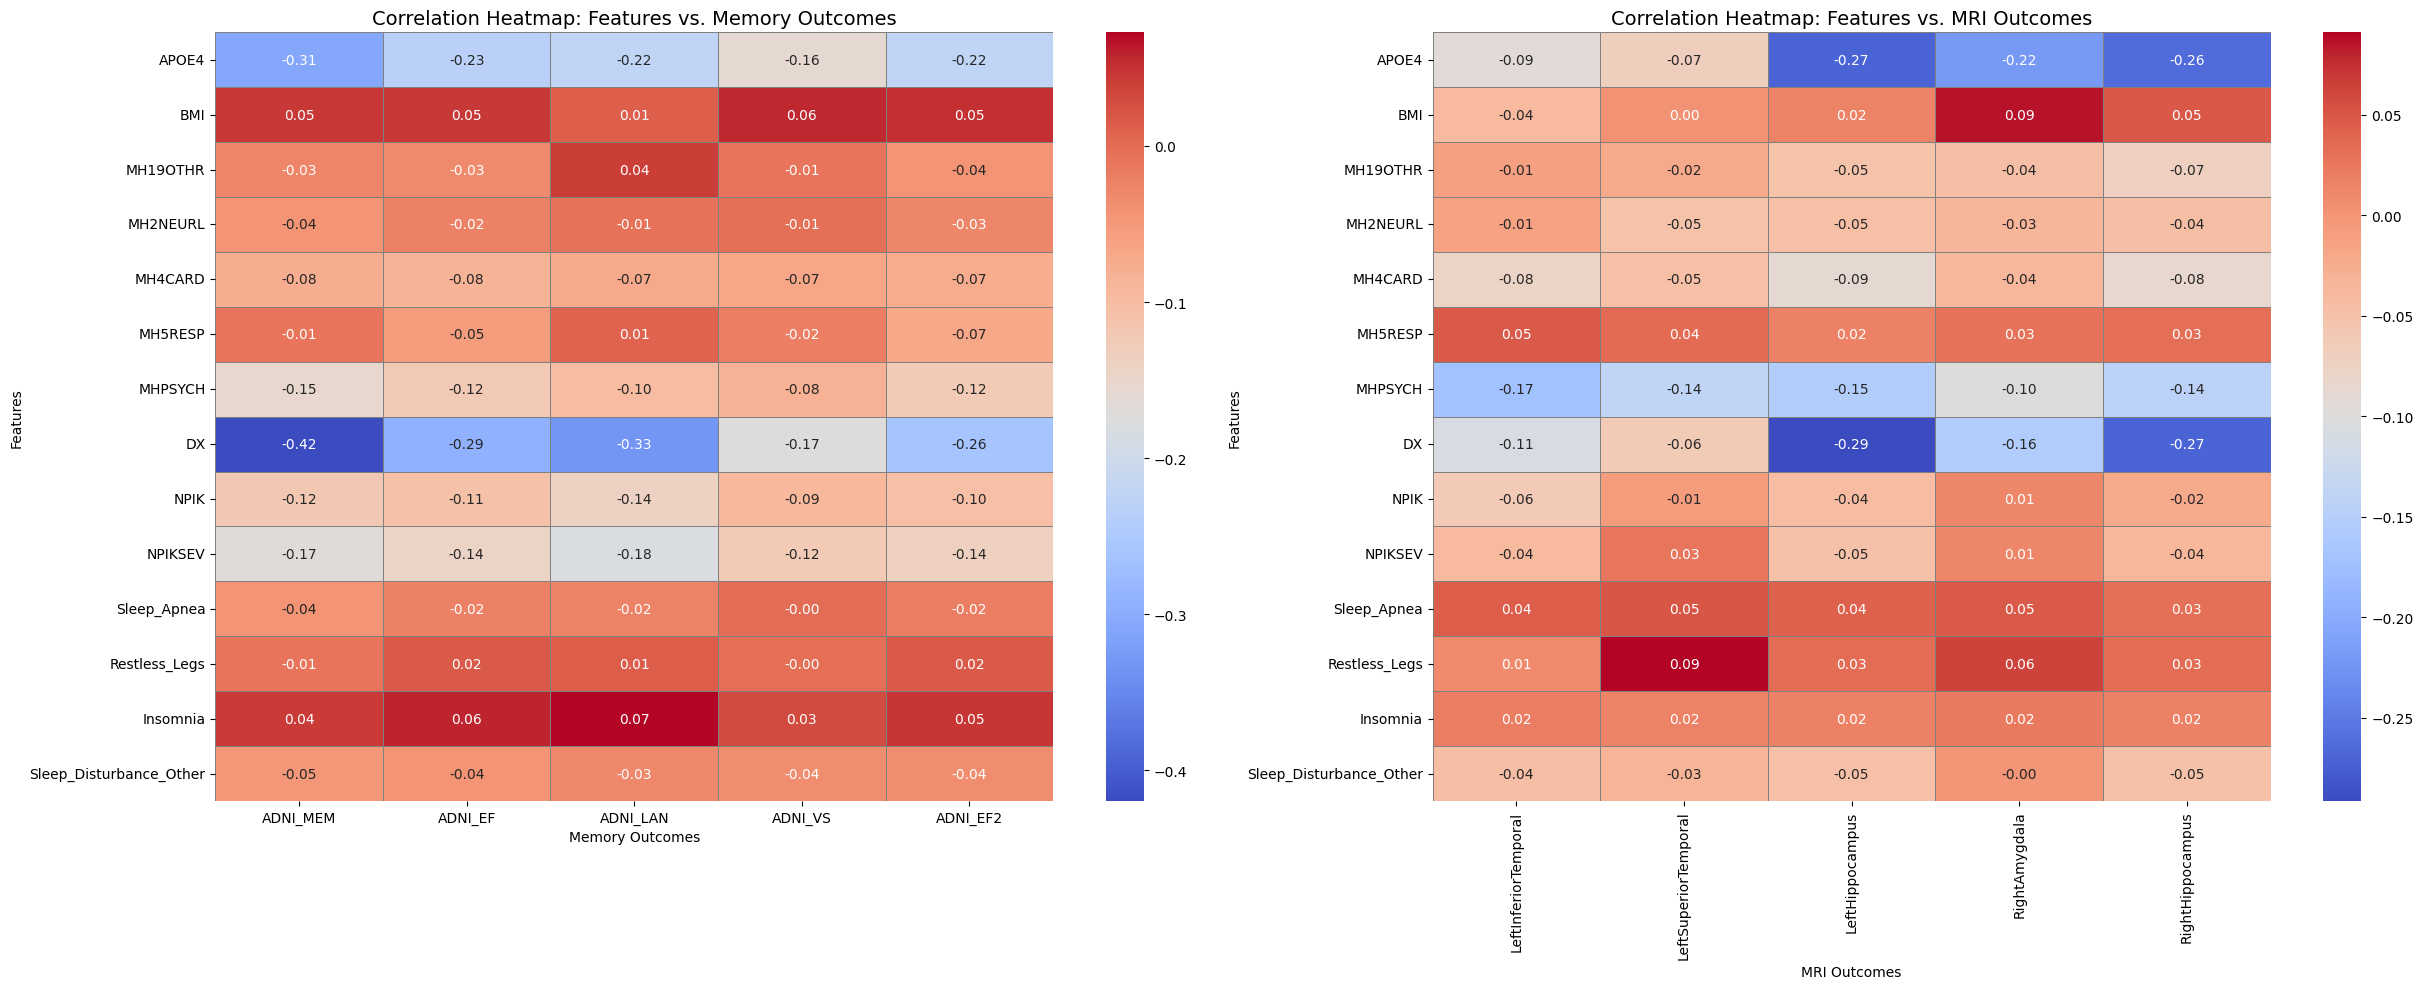

In [81]:
combined_features = model2_preds + sleep_vars
memory_corr_columns = [col for col in combined_features +
                       memory_outcomes if col in merge.columns]
mri_corr_columns = [col for col in combined_features +
                    list(top_5_mri_outcomes) if col in merge.columns]
memory_corr_data = merge[memory_corr_columns].dropna()
mri_corr_data = merge[mri_corr_columns].dropna()

correlation_memory = memory_corr_data.corr()
correlation_memory_features = correlation_memory.loc[
    [col for col in combined_features if col in memory_corr_data.columns],
    [col for col in memory_outcomes if col in memory_corr_data.columns]
]

correlation_mri = mri_corr_data.corr()
correlation_mri_features = correlation_mri.loc[
    [col for col in combined_features if col in mri_corr_data.columns],
    [col for col in top_5_mri_outcomes if col in mri_corr_data.columns]
]
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.heatmap(
    correlation_memory_features, annot=True, fmt=".2f",
    cmap='coolwarm', cbar=True, ax=axes[0], linewidths=0.5, linecolor='gray'
)
axes[0].set_title(
    'Correlation Heatmap: Features vs. Memory Outcomes', fontsize=14)
axes[0].set_xlabel('Memory Outcomes')
axes[0].set_ylabel('Features')
sns.heatmap(
    correlation_mri_features, annot=True, fmt=".2f",
    cmap='coolwarm', cbar=True, ax=axes[1], linewidths=0.5, linecolor='gray'
)
axes[1].set_title(
    'Correlation Heatmap: Features vs. MRI Outcomes', fontsize=14)
axes[1].set_xlabel('MRI Outcomes')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.show()

In [87]:
DX_bl_ = {0: 'AD', 1: 'CN', 2: 'LMCI'}
DX_ = {0: 'CN', 1: 'Dementia', 2: 'MCI'}
VISCODE_ = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}

In [88]:
merge['DX_bl_decoded'] = merge['DX_bl'].map(DX_bl_)
merge['DX_decoded'] = merge['DX'].map(DX_)

In [89]:
dx_transitions = []

for rid, group in merge.groupby('RID'):
    dx_seq = group['DX_decoded'].dropna().tolist()
    dx_bl = group['DX_bl_decoded'].iloc[0]

    dx_set = set(dx_seq)

    dx_seq = ['AD' if d == 'Dementia' else d for d in dx_seq]
    dx_set = set(dx_seq)

    if len(dx_set) == 1 and dx_seq[0] == dx_bl:
        dx_status = 'Stable'
    elif dx_bl in ['CN', 'LMCI'] and 'AD' in dx_set:
        dx_status = 'Progressed'
    elif dx_bl == 'AD' and any(x in dx_set for x in ['CN', 'MCI', 'LMCI']):
        dx_status = 'Improved'
    else:
        dx_status = 'Mixed'

    dx_transitions.append({'RID': rid, 'DX_Transition': dx_status})

In [91]:
npiksev_transitions = []

for rid, group in merge.groupby('RID'):
    sev_values = group['NPIKSEV'].dropna().tolist()

    if len(sev_values) <= 1:
        trend = 'Flat'
    else:
        diffs = pd.Series(sev_values).diff().dropna()
        if all(d == 0 for d in diffs):
            trend = 'Flat'
        elif all(d <= 0 for d in diffs) and any(d < 0 for d in diffs):
            trend = 'Improved'
        elif all(d >= 0 for d in diffs) and any(d > 0 for d in diffs):
            trend = 'Worsened'
        else:
            trend = 'Mixed'

    npiksev_transitions.append({'RID': rid, 'NPIKSEV_Trend': trend})

In [94]:
merge['NPIKSEV'].value_counts()

0.0    1759
1.0     213
2.0      95
3.0      21
Name: NPIKSEV, dtype: int64

In [95]:
dx_transition_df = pd.DataFrame(dx_transitions)
npiksev_transition_df = pd.DataFrame(npiksev_transitions)

In [97]:
npiksev_transition_df['NPIKSEV_Trend'].value_counts()

Flat        335
Mixed       101
Worsened     59
Improved     27
Name: NPIKSEV_Trend, dtype: int64

In [98]:
dx_transition_df['DX_Transition'].value_counts()

Stable        273
Mixed         151
Progressed     95
Improved        3
Name: DX_Transition, dtype: int64

In [99]:
transition_summary = pd.merge(
    dx_transition_df, npiksev_transition_df, on='RID')

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

df_long = transition_summary.copy()
df_long = df_long[['DX_Transition', 'NPIKSEV_Trend']]
df_long['Count'] = 1

color_map = {
    'Stable': 'black',
    'Improved': 'green',
    'Progressed': 'red',
    'Mixed': 'blue'
}

df_long['Color'] = df_long['DX_Transition'].map(color_map)

grouped = df_long.groupby(
    ['DX_Transition', 'NPIKSEV_Trend', 'Color']).size().reset_index(name='Count')
fig = go.Figure(data=[
    go.Parcats(
        dimensions=[
            dict(label='Diagnosis Transition',
                 values=grouped['DX_Transition']),
            dict(label='Sleep Severity Trend', values=grouped['NPIKSEV_Trend'])
        ],
        line=dict(
            color=grouped['Color'].apply(lambda c: c),
            colorscale=None
        ),
        counts=grouped['Count']
    )
])

fig.update_layout(
    title='Parallel Categories Plot: Diagnosis vs. Sleep Severity Trends',
    font=dict(size=14)
)

fig.show()

C:\Users\anisr\AppData\Local\Temp\ipykernel_18908\1672972105.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




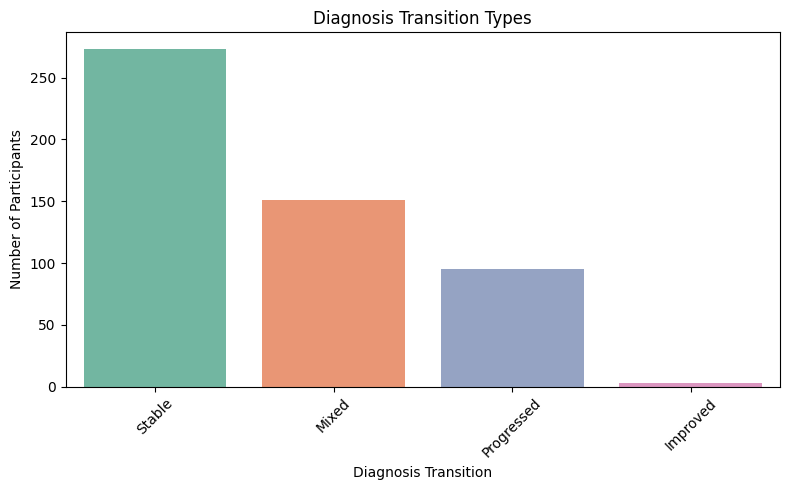

In [106]:
dx_counts = transition_summary['DX_Transition'].value_counts().reset_index()
dx_counts.columns = ['Transition', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=dx_counts, x='Transition', y='Count', palette='Set2')
plt.title('Diagnosis Transition Types')
plt.xlabel('Diagnosis Transition')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

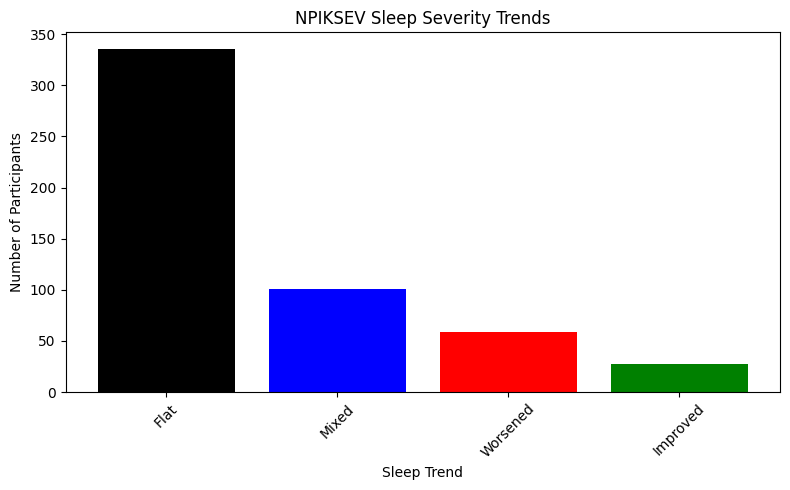

In [110]:
sleep_colors = {
    'Flat': 'black',
    'Improved': 'green',
    'Worsened': 'red',
    'Mixed': 'blue'
}

sleep_counts = transition_summary['NPIKSEV_Trend'].value_counts().reset_index()
sleep_counts.columns = ['Trend', 'Count']
sleep_counts['Color'] = sleep_counts['Trend'].map(sleep_colors)
plt.figure(figsize=(8, 5))
bars = plt.bar(sleep_counts['Trend'],
               sleep_counts['Count'], color=sleep_counts['Color'])
plt.title('NPIKSEV Sleep Severity Trends')
plt.xlabel('Sleep Trend')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()